Two approaches for this problem

1. Label the images as odd even (1/0) and model a binary classification problem
2. Model a multiclass classification problem, and apply odd/even filter on top of its predictions

The latter gives accuracy improvement of 96% over the former; while the former fails to perform good on binary setting

In [ ]:
pip install -q -U tensorflow-addons

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

In [4]:
x_train.shape, y_train

((60000, 28, 28), array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

### Rotate Images

In [5]:
import tensorflow_addons as tfa

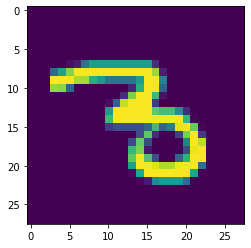

In [6]:
_ = plt.imshow(x_train[30])


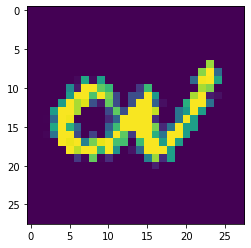

In [7]:
rotate = tfa.image.rotate(x_train[30], tf.constant(180.0))
_ = plt.imshow(rotate)


In [8]:
%%time
rotated_x_train = []
for img in tqdm_notebook(x_train):
  rotate = tfa.image.rotate(img, tf.constant(180.0))
  rotated_x_train.append(rotate)

rotated_x_test = []
for img in tqdm_notebook(x_test):
  rotate = tfa.image.rotate(img, tf.constant(180.0))
  rotated_x_test.append(rotate)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/60000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6min 13s, sys: 11.4 s, total: 6min 24s
Wall time: 6min 35s


In [9]:
rotated_x_train_final = np.asarray(rotated_x_train)
rotated_x_test_final = np.asarray(rotated_x_test)


In [10]:
rotated_x_train_final.shape, x_train.shape

((60000, 28, 28), (60000, 28, 28))

In [11]:
x_train_final = np.concatenate((rotated_x_train_final, x_train))
x_test_final = np.concatenate((rotated_x_test_final, x_test))

In [12]:
y_train_final = np.concatenate((y_train, y_train))
y_test_final = np.concatenate((y_test, y_test))

### Setup training

In [13]:
# # Make odd-1/even-0 labels

y_train_NUM = np.asarray([int(x%2) for x in y_train_final])
y_test_NUM = np.asarray([int(x%2) for x in y_test_final])

In [14]:
np.bincount(y_train_final)

array([11846, 13484, 11916, 12262, 11684, 10842, 11836, 12530, 11702,
       11898])

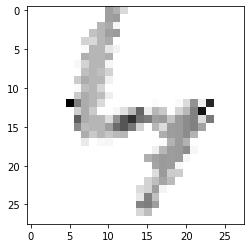

In [15]:
# Normalization
x_train_final = tf.keras.utils.normalize(x_train_final, axis = 1)
x_test_final = tf.keras.utils.normalize(x_test_final, axis = 1)
plt.imshow(x_train_final[0], cmap = plt.cm.binary)


In [16]:
# Resize images for convolution

IMG_SIZE=28
# -1 is a shorthand, which returns the length of the dataset
x_trainr = np.array(x_train_final).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_testr = np.array(x_test_final).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print("Training Samples dimension", x_trainr.shape)
print("Testing Samples dimension", x_testr.shape)

# Training Samples dimension (60000, 28, 28, 1)
# Testing Samples dimension (10000, 28, 28, 1)


Training Samples dimension (120000, 28, 28, 1)
Testing Samples dimension (20000, 28, 28, 1)


In [39]:
# Creating the network
model = Sequential()

### First Convolution Layer
# 64 -> number of filters, (3,3) -> size of each kernal,
model.add(Conv2D(64, (3,3), input_shape = x_trainr.shape[1:])) # For first layer we have to mention the size of input
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

### Second Convolution Layer
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

### Third Convolution Layer
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

### Fully connected layer 1
model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

### Fully connected layer 2
model.add(Dense(32))
model.add(Activation("relu"))

### Fully connected layer 3, output layer must be equal to number of classes
model.add(Dense(10))
model.add(Activation("softmax"))


In [40]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 activation_18 (Activation)  (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 activation_19 (Activation)  (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                 

In [41]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer="adam", metrics=['accuracy'])

In [43]:
%%time
model.fit(x_trainr, y_train_final, epochs=5, validation_split = 0.3)


Epoch 1/5
2625/2625 [==============================] - 13s 5ms/step - loss: 0.3589 - accuracy: 0.8846 - val_loss: 0.2205 - val_accuracy: 0.9315
Epoch 2/5
2625/2625 [==============================] - 11s 4ms/step - loss: 0.1202 - accuracy: 0.9632 - val_loss: 0.1442 - val_accuracy: 0.9566
Epoch 3/5
2625/2625 [==============================] - 11s 4ms/step - loss: 0.0847 - accuracy: 0.9737 - val_loss: 0.1207 - val_accuracy: 0.9636
Epoch 4/5
2625/2625 [==============================] - 12s 5ms/step - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.1357 - val_accuracy: 0.9602
Epoch 5/5
2625/2625 [==============================] - 12s 4ms/step - loss: 0.0499 - accuracy: 0.9843 - val_loss: 0.1056 - val_accuracy: 0.9688
CPU times: user 1min 2s, sys: 4.51 s, total: 1min 7s
Wall time: 59 s


In [44]:
# Evaluating the accuracy on the test data
test_loss, test_acc = model.evaluate(x_testr, y_test_final)
print("Test Loss on 10,000 test samples", test_loss)
print("Test Accuracy on 10,000 test samples", test_acc)


625/625 [==============================] - 2s 2ms/step - loss: 0.0829 - accuracy: 0.9751
Test Loss on 10,000 test samples 0.08293270319700241
Test Accuracy on 10,000 test samples 0.9750999808311462


[[5.34945005e-12 1.15562226e-09 5.41744463e-08 ... 9.99978781e-01
  2.35382558e-09 9.81101766e-06]
 [1.31005982e-05 2.26203876e-04 9.99662995e-01 ... 1.43586453e-06
  1.54046738e-05 4.92869617e-07]
 [1.89216044e-05 9.92391884e-01 2.39789090e-03 ... 1.96725316e-03
  1.38439040e-03 1.86341073e-04]
 ...
 [2.23810757e-13 1.54987958e-07 1.05984457e-08 ... 6.68127541e-06
  1.21885969e-04 1.06278583e-06]
 [5.31267005e-06 2.04637356e-08 2.24069413e-06 ... 9.82291681e-07
  1.21042624e-01 1.88745838e-03]
 [2.00165960e-04 6.28950656e-04 1.28517847e-03 ... 5.93908044e-06
  2.41267815e-04 3.58008314e-04]]
7


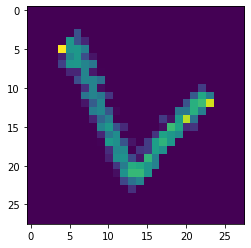

In [23]:
predictions = model.predict([x_testr])
print(predictions)

plt.imshow(x_test_final[0])
print(np.argmax(predictions[0]))
# 7


In [24]:
test_preds = np.argmax(predictions, axis=1)

test_preds_odd_even = np.asarray([int(x%2) for x in test_preds])

In [25]:
np.mean(test_preds_odd_even==y_test_NUM)

# ODD EVEN test accuracy

0.98565

In [29]:
# Save the model
model.save('./model_ckpt')


INFO:tensorflow:Assets written to: ./model_ckpt/assets


In [30]:
# Loading back the model
from tensorflow import keras
test_model = keras.models.load_model('./model_ckpt')


### Test on sample image

In [ ]:
import cv2
img = cv2.imread('three.png')
plt.imshow(img)


In [ ]:
img.shape
# (28, 28, 3)

# Converting to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape
# (28, 28)

# Resizing to a 28x28 image
# Please note my image was already in correct dimension
resized = cv2.resize(gray, (28,28), interpolation = cv2.INTER_AREA)
resized.shape
# (28, 28)

# 0-1 scaling
newimg = tf.keras.utils.normalize(resized, axis = 1)

# For kernal operations
newimg = np.array(newimg).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

newimg.shape
# (1, 28, 28, 1)

predictions = model.predict(newimg)
print(np.argmax(predictions[0]))
# 3
